# Autoencoder Super-Resolution

An autoencoder is a type of artificial neural network used to learn efficient codings of unlabeled data (unsupervised learning). 

Train an [Autoencoder Convolutional Network](https://mpolinowski.github.io/docs/IoT-and-Machine-Learning/ML/2023-03-24-tensorflow-unsupervised-learning-autoencoders/2023-03-24) to upscale noisy, compressed images.

In [1]:
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import random
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, UpSampling2D, Dropout
from tensorflow.keras.models import Model

2023-03-25 20:41:02.279823: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BATCH_SIZE = 32
SEED = 42
IMAGE_SIZE = 250
DATA_DIR = "../datasets/Labeled_Faces_in_the_Wild_Home/lfw"

Download the [Labeled Faces in the Wild](https://vis-www.cs.umass.edu/lfw/) Dataset

> `wget http://vis-www.cs.umass.edu/lfw/lfw.tgz`


## Load and Preprocess the Dataset

2023-03-25 20:41:16.006988: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-25 20:41:16.026428: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-25 20:41:16.026610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-25 20:41:16.027024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

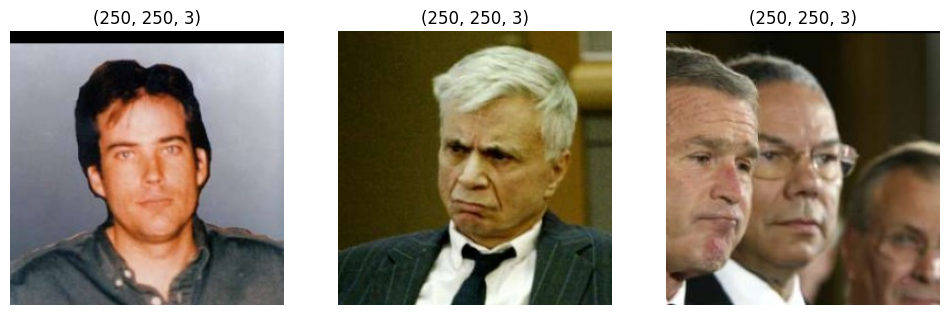

In [3]:
# inspect a few images
def view_random_image(target_dir):
    target_folder = str(target_dir)
    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(str(img.shape))
    plt.axis("off")
    
    return tf.constant(img)

fig = plt.figure(figsize=(12, 6))
plot1 = fig.add_subplot(1, 3, 1)
image_0 = view_random_image(target_dir = DATA_DIR)
plot2 = fig.add_subplot(1, 3, 2)
image_1 = view_random_image(target_dir = DATA_DIR)
plot2 = fig.add_subplot(1, 3, 3)
image_2 = view_random_image(target_dir = DATA_DIR)

![Autoencoder Super-Resolution](../assets/05_Tensorflow_Unsupervised_Learning_12.png)

In [4]:
# since we are not going to classify this dataset
# we can copy all files into the same folder
dataset = glob.glob(DATA_DIR+'/**/*.jpg') #returns path of images
print(len(dataset), dataset[:1])
# 13233 ['../datasets/Labeled_Faces_in_the_Wild_Home/lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg']

for file in dataset:
    shutil.move(file, DATA_DIR)

images = glob.glob(DATA_DIR+'/*.jpg')
print(len(images), images[:1])
# 13233 ['../datasets/Labeled_Faces_in_the_Wild_Home/lfw/Aaron_Eckhart_0001.jpg']

0 []
13233 ['../datasets/Labeled_Faces_in_the_Wild_Home/lfw/Karen_Lynn_Gorney_0001.jpg']


In [5]:
# now with the images in place we can split them
images = glob.glob(DATA_DIR+'/*.jpg')

train_X, val_X = train_test_split(images, test_size=0.2, random_state=SEED)
print(len(train_X), len(val_X))
# 10586 2647

10586 2647


In [6]:
# the dataset now needs to be split into
# a set of the source images and a set of
# low resolution versions of those images
def get_training_data_48(images_location):
  y_source_image = []
  X_lowres_image = []

  for img in os.listdir(images_location):
    try:
      image = cv2.imread(f"{images_location}/{img}", cv2.IMREAD_UNCHANGED)
      reshaped_image = cv2.resize(image, (144, 144))
      image_rgb = cv2.cvtColor(reshaped_image, cv2.COLOR_BGR2RGB)
      if reshaped_image.shape[-1] == 3:
        y_source_image.append(image_rgb)

      image = cv2.resize(image, (48, 48))
      reshaped_image = cv2.resize(image, (144, 144))
      image_rgb = cv2.cvtColor(reshaped_image, cv2.COLOR_BGR2RGB)
      if reshaped_image.shape[-1] == 3:
        X_lowres_image.append(image_rgb)

    except Exception as e:
      # print(str(e))
      pass
      

  return (np.array(X_lowres_image), np.array(y_source_image))

In [7]:
lowres_images, source_images = get_training_data_48(DATA_DIR)
print(lowres_images.shape, source_images.shape)
# (13233, 144, 144, 3) (13233, 144, 144, 3)

(13233, 144, 144, 3) (13233, 144, 144, 3)


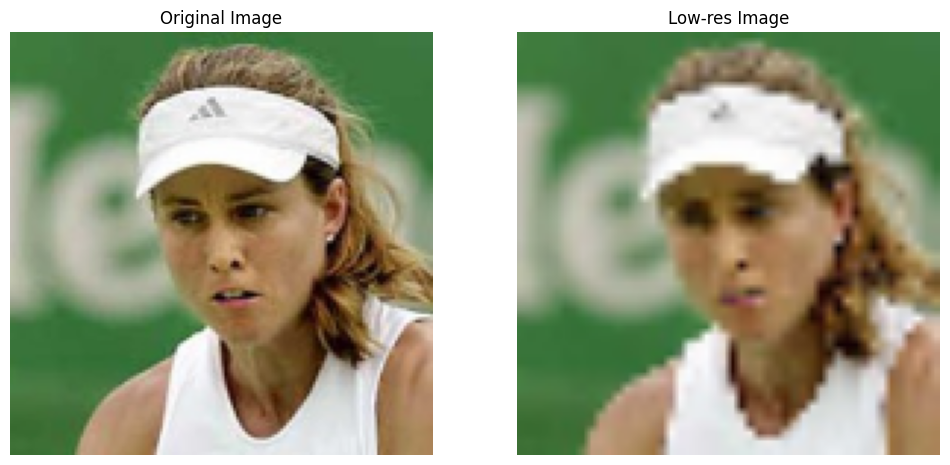

In [8]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images[13131])

plt.subplot(1, 2, 2)
plt.title("Low-res Image")
plt.axis(False)
plt.imshow(lowres_images[13131])

![Autoencoder Super-Resolution](../assets/05_Tensorflow_Unsupervised_Learning_13.png)

## Build the Autoencoder

In [9]:
input_img = tf.keras.layers.Input(shape=(144, 144, 3))

l1 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l1)
l3 = MaxPool2D(padding='same')(l2)

l4 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l4)
l6 = MaxPool2D(padding='same')(l5)

l7 = Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l6)

l8 = UpSampling2D()(l7)
l9 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l9)

l11 = tf.keras.layers.add([l10, l5])

l12 = UpSampling2D()(l11)
l13 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l13)

l15 = tf.keras.layers.add([l14, l2])

decoded_image = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-10))(l15)

auto_encoder = Model(inputs=(input_img), outputs=decoded_image)

In [10]:
tf.random.set_seed=SEED
auto_encoder.compile(optimizer='adadelta', loss='mean_squared_error')
auto_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 144, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 144, 144, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [11]:
auto_encoder.fit(lowres_images,
                 source_images,
                 epochs=25,
                 batch_size=BATCH_SIZE,
                 shuffle=True)

# Epoch 1/5
# 229s 525ms/step - loss: 6488.4028
# Epoch 2/25
# 213s 514ms/step - loss: 4692.7637
# Epoch 3/25
# 211s 511ms/step - loss: 1421.0702
# Epoch 4/25
# 211s 510ms/step - loss: 543.7433
# Epoch 5/25
# 211s 509ms/step - loss: 414.3141
# Epoch 6/25
# 194s 468ms/step - loss: 357.2447
# Epoch 7/25
# 194s 467ms/step - loss: 320.0330
# Epoch 8/25
# 193s 467ms/step - loss: 294.0082
# Epoch 9/25
# 193s 467ms/step - loss: 274.6338
# Epoch 10/25
# 193s 467ms/step - loss: 259.9402
# Epoch 11/25
# 193s 467ms/step - loss: 248.2195
# Epoch 12/25
# 193s 467ms/step - loss: 238.6665
# Epoch 13/25
# 193s 467ms/step - loss: 230.7052
# Epoch 14/25
# 193s 467ms/step - loss: 224.1879
# Epoch 15/25
# 193s 467ms/step - loss: 218.4927
# Epoch 16/25
# 193s 467ms/step - loss: 213.6586
# Epoch 17/25
# 193s 467ms/step - loss: 209.4044
# Epoch 18/25
# 193s 467ms/step - loss: 205.5302
# Epoch 19/25
# 193s 467ms/step - loss: 202.2275
# Epoch 20/25
# 193s 467ms/step - loss: 199.2723
# Epoch 21/25
# 193s 467ms/step - loss: 196.5294
# Epoch 22/25
# 193s 467ms/step - loss: 187.7074
# Epoch 23/25
# 193s 467ms/step - loss: 171.8884
# Epoch 24/25
# 193s 467ms/step - loss: 169.2720
# Epoch 25/25
# 193s 467ms/step - loss: 167.2259

Epoch 1/25


2023-03-25 20:42:46.910307: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-25 20:42:47.831422: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-25 20:42:48.529686: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-03-25 20:42:49.506885: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if m

414/414 [==============================] - 229s 525ms/step - loss: 6488.4028
Epoch 2/25
414/414 [==============================] - 213s 514ms/step - loss: 4692.7637
Epoch 3/25
414/414 [==============================] - 211s 511ms/step - loss: 1421.0702
Epoch 4/25
414/414 [==============================] - 211s 510ms/step - loss: 543.7433
Epoch 5/25
414/414 [==============================] - 211s 509ms/step - loss: 414.3141
Epoch 6/25
414/414 [==============================] - 194s 468ms/step - loss: 357.2447
Epoch 7/25
414/414 [==============================] - 194s 467ms/step - loss: 320.0330
Epoch 8/25
414/414 [==============================] - 193s 467ms/step - loss: 294.0082
Epoch 9/25
414/414 [==============================] - 193s 467ms/step - loss: 274.6338
Epoch 10/25
414/414 [==============================] - 193s 467ms/step - loss: 259.9402
Epoch 11/25
414/414 [==============================] - 193s 467ms/step - loss: 248.2195
Epoch 12/25
414/414 [============================

In [17]:
upscaled_images = auto_encoder.predict(lowres_images[0:9])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


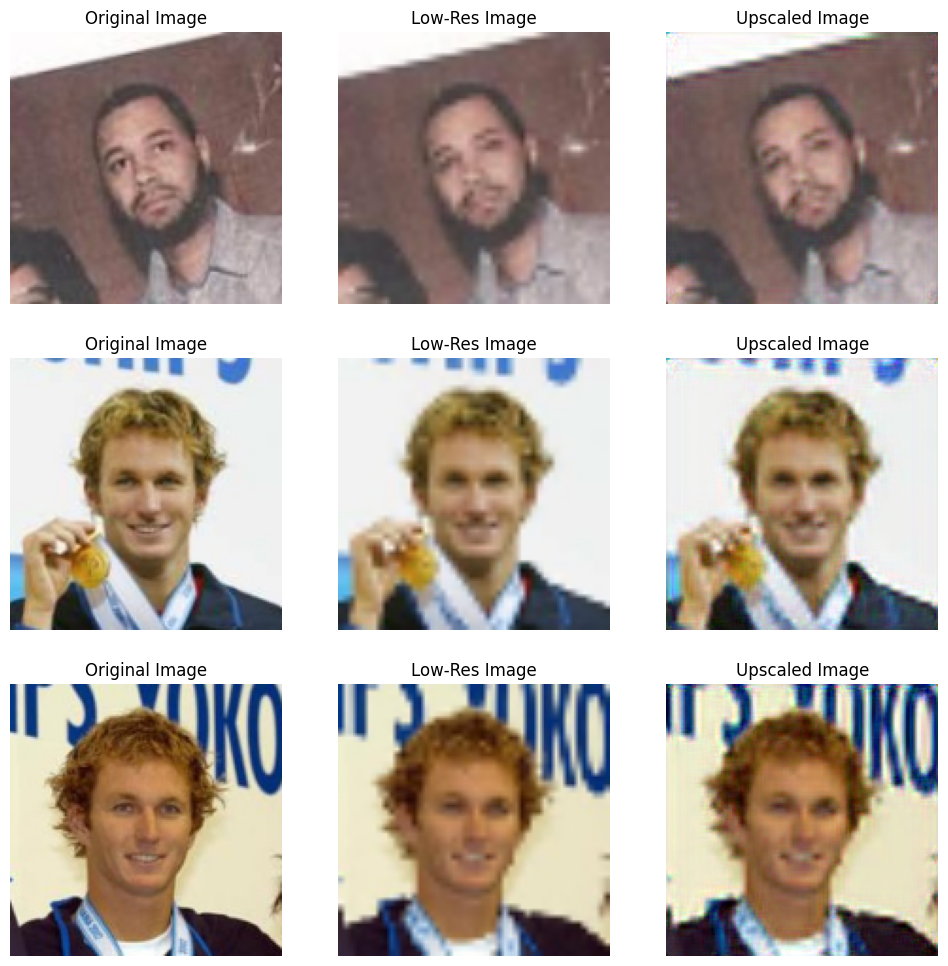

In [18]:
# plot results
plt.figure(figsize=(12, 12))
# ROW 1
plt.subplot(3, 3, 1)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images[3])
plt.subplot(3, 3, 2)
plt.title("Low-Res Image")
plt.axis(False)
plt.imshow(lowres_images[3])
plt.subplot(3, 3, 3)
plt.title("Upscaled Image")
plt.axis(False)
plt.imshow(upscaled_images[3]/255)
# ROW 2
plt.subplot(3, 3, 4)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images[4])
plt.subplot(3, 3, 5)
plt.title("Low-Res Image")
plt.axis(False)
plt.imshow(lowres_images[4])
plt.subplot(3, 3, 6)
plt.title("Upscaled Image")
plt.axis(False)
plt.imshow(upscaled_images[4]/255)
# ROW 3
plt.subplot(3, 3, 7)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images[5])
plt.subplot(3, 3, 8)
plt.title("Low-Res Image")
plt.axis(False)
plt.imshow(lowres_images[5])
plt.subplot(3, 3, 9)
plt.title("Upscaled Image")
plt.axis(False)
plt.imshow(upscaled_images[5]/255)

![Autoencoder Super-Resolution](../assets/05_Tensorflow_Unsupervised_Learning_14.png)

![Autoencoder Super-Resolution](../assets/05_Tensorflow_Unsupervised_Learning_15.png)

# Re-run with a lower Compression Factor

In this example the reconstructed image looks very close to the low-resolution input image - which is already impressive knowing how much this information has been condensed. The original paper this is based on used larger 224x224px input images with a lower compression factor than the example above:

* 144x144px input images
* Compressed to 48x48px
* Inflated back to 144x144px

I cannot go higher with the resolution of the input image since this makes my graphic card very unhappy :(. But I can decrease the compression factor to give my model more details to work with - `144` -> `72` -> `144`:

In [27]:
def get_training_data_72(images_location):
  y_source_image = []
  X_lowres_image = []

  for img in os.listdir(images_location):
    try:
      image = cv2.imread(f"{images_location}/{img}", cv2.IMREAD_UNCHANGED)
      reshaped_image = cv2.resize(image, (144, 144))
      image_rgb = cv2.cvtColor(reshaped_image, cv2.COLOR_BGR2RGB)
      if reshaped_image.shape[-1] == 3:
        y_source_image.append(image_rgb)

      image = cv2.resize(image, (72, 72))
      reshaped_image = cv2.resize(image, (144, 144))
      image_rgb = cv2.cvtColor(reshaped_image, cv2.COLOR_BGR2RGB)
      if reshaped_image.shape[-1] == 3:
        X_lowres_image.append(image_rgb)

    except Exception as e:
      # print(str(e))
      pass
      

  return (np.array(X_lowres_image), np.array(y_source_image))

In [28]:
lowres_images_72, source_images_72 = get_training_data_72(DATA_DIR)
print(lowres_images_72.shape, source_images_72.shape)
# (13233, 144, 144, 3) (13233, 144, 144, 3)

(13233, 144, 144, 3) (13233, 144, 144, 3)


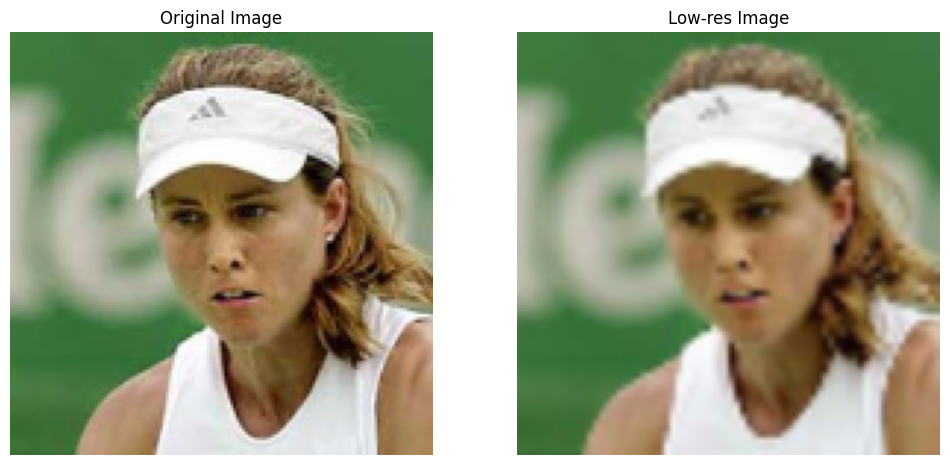

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images_72[13131])

plt.subplot(1, 2, 2)
plt.title("Low-res Image")
plt.axis(False)
plt.imshow(lowres_images_72[13131])

![Autoencoder Super-Resolution](../assets/05_Tensorflow_Unsupervised_Learning_16.png)

In [31]:
auto_encoder.fit(lowres_images_72,
                 source_images_72,
                 epochs=25,
                 batch_size=BATCH_SIZE,
                 shuffle=True)

# Epoch 1/25
# 262s 633ms/step - loss: 103.1866
# Epoch 2/25
# 229s 553ms/step - loss: 97.3206
# Epoch 3/25
# 229s 553ms/step - loss: 93.4157
# Epoch 4/25
# 229s 553ms/step - loss: 90.4040
# Epoch 5/25
# 232s 560ms/step - loss: 87.6966
# Epoch 6/25
# 261s 631ms/step - loss: 85.4864
# Epoch 7/25
# 244s 589ms/step - loss: 83.4865
# Epoch 8/25
# 230s 555ms/step - loss: 81.8133
# Epoch 9/25
# 230s 556ms/step - loss: 80.1447
# Epoch 10/25
# 228s 550ms/step - loss: 78.6784
# Epoch 11/25
# 232s 560ms/step - loss: 77.3202
# Epoch 12/25
# 223s 538ms/step - loss: 76.0533
# Epoch 13/25
# 222s 536ms/step - loss: 74.9465
# Epoch 14/25
# 212s 512ms/step - loss: 73.8465
# Epoch 15/25
# 228s 552ms/step - loss: 72.7948
# Epoch 16/25
# 256s 618ms/step - loss: 71.9504
# Epoch 17/25
# 240s 579ms/step - loss: 71.0116
# Epoch 18/25
# 252s 608ms/step - loss: 70.2642
# Epoch 19/25
# 270s 652ms/step - loss: 69.4523
# Epoch 20/25
# 266s 642ms/step - loss: 68.6822
# Epoch 21/25
# 262s 632ms/step - loss: 67.9245
# Epoch 22/25
# 321s 776ms/step - loss: 67.3510
# Epoch 23/25
# 325s 784ms/step - loss: 66.6649
# Epoch 24/25
# 260s 627ms/step - loss: 66.0176
# Epoch 25/25
# 273s 660ms/step - loss: 65.4639

Epoch 1/25
414/414 [==============================] - 262s 633ms/step - loss: 103.1866
Epoch 2/25
414/414 [==============================] - 229s 553ms/step - loss: 97.3206
Epoch 3/25
414/414 [==============================] - 229s 553ms/step - loss: 93.4157
Epoch 4/25
414/414 [==============================] - 229s 553ms/step - loss: 90.4040
Epoch 5/25
414/414 [==============================] - 232s 560ms/step - loss: 87.6966
Epoch 6/25
414/414 [==============================] - 261s 631ms/step - loss: 85.4864
Epoch 7/25
414/414 [==============================] - 244s 589ms/step - loss: 83.4865
Epoch 8/25
414/414 [==============================] - 230s 555ms/step - loss: 81.8133
Epoch 9/25
414/414 [==============================] - 230s 556ms/step - loss: 80.1447
Epoch 10/25
414/414 [==============================] - 228s 550ms/step - loss: 78.6784
Epoch 11/25
414/414 [==============================] - 232s 560ms/step - loss: 77.3202
Epoch 12/25
414/414 [==============================

In [32]:
upscaled_images_72 = auto_encoder.predict(lowres_images_72[0:9])

1/1 [==============================] - 0s 22ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


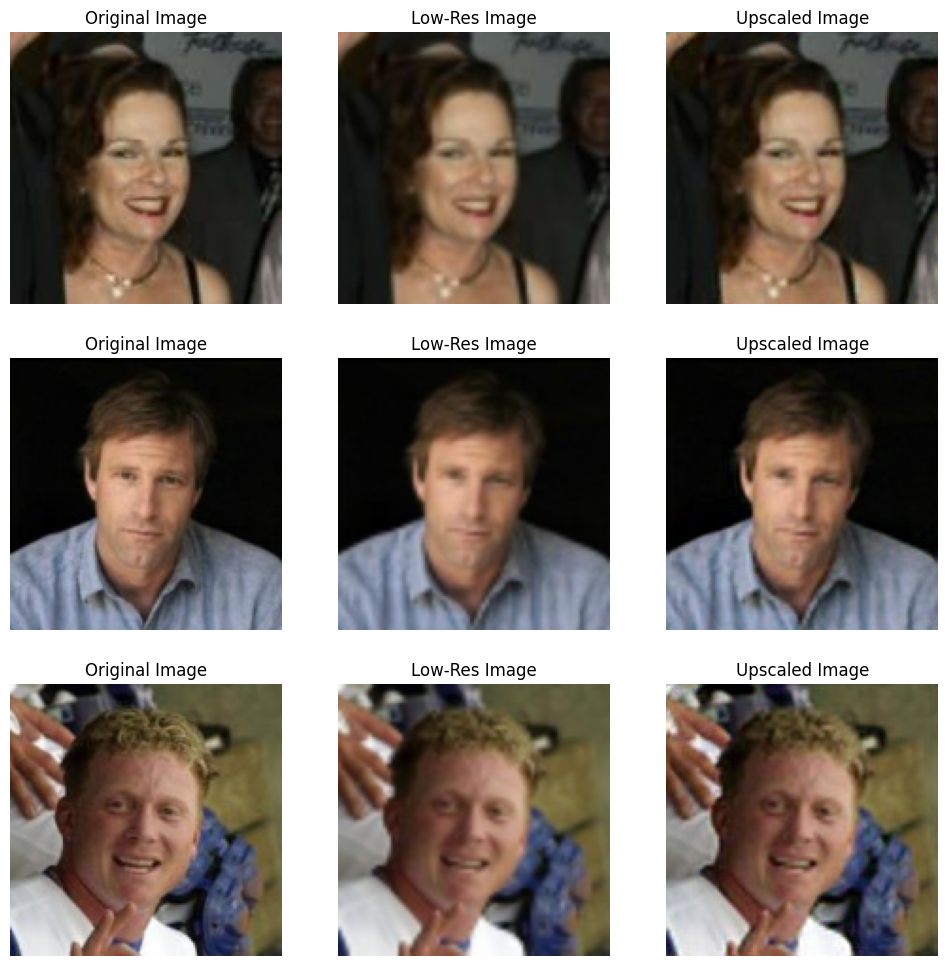

In [34]:
# plot results
plt.figure(figsize=(12, 12))
# ROW 1
plt.subplot(3, 3, 1)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images_72[0])
plt.subplot(3, 3, 2)
plt.title("Low-Res Image")
plt.axis(False)
plt.imshow(lowres_images_72[0])
plt.subplot(3, 3, 3)
plt.title("Upscaled Image")
plt.axis(False)
plt.imshow(upscaled_images_72[0]/255)
# ROW 2
plt.subplot(3, 3, 4)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images_72[1])
plt.subplot(3, 3, 5)
plt.title("Low-Res Image")
plt.axis(False)
plt.imshow(lowres_images_72[1])
plt.subplot(3, 3, 6)
plt.title("Upscaled Image")
plt.axis(False)
plt.imshow(upscaled_images_72[1]/255)
# ROW 3
plt.subplot(3, 3, 7)
plt.title("Original Image")
plt.axis(False)
plt.imshow(source_images_72[2])
plt.subplot(3, 3, 8)
plt.title("Low-Res Image")
plt.axis(False)
plt.imshow(lowres_images_72[2])
plt.subplot(3, 3, 9)
plt.title("Upscaled Image")
plt.axis(False)
plt.imshow(upscaled_images_72[2]/255)

![Autoencoder Super-Resolution](../assets/05_Tensorflow_Unsupervised_Learning_17.png)

![Autoencoder Super-Resolution](../assets/05_Tensorflow_Unsupervised_Learning_18.png)

Now this does look a lot better. There is a clear improvement over the low-resolution image. But it is not yet directly compareable in details to the source image.